# Image reconstruction with CG-SENSE

[![View on website](https://img.shields.io/badge/-View%20on%20website-128091?labelColor=grey&logo=)](https://mrphys.github.io/tensorflow-mri/tutorials/recon/cg_sense)
[![Run in Colab](https://img.shields.io/badge/-Run%20in%20Colab-128091?labelColor=grey&logo=googlecolab)](https://colab.research.google.com/github/mrphys/tensorflow-mri/blob/master/tools/docs/tutorials/recon/cg_sense.ipynb)
[![View on GitHub](https://img.shields.io/badge/-View%20on%20GitHub-128091?labelColor=grey&logo=github)](https://github.com/mrphys/tensorflow-mri/blob/master/tools/docs/tutorials/recon/cg_sense.ipynb)
[![Download notebook](https://img.shields.io/badge/-Download%20notebook-128091?labelColor=grey&logo=)](https://raw.githubusercontent.com/mrphys/tensorflow-mri/master/tools/docs/tutorials/recon/cg_sense.ipynb)

## Set up TensorFlow MRI
If you have not yet installed TensorFlow MRI in your environment, you may do so
now using `pip`: 

In [1]:
%pip install --quiet tensorflow-mri
# Upgrade Matplotlib. Versions older than 3.5.x may cause an error below.
%pip install --quiet --upgrade matplotlib

You should consider upgrading via the '/usr/local/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Then, import the package into your program to get started:

In [2]:
import tensorflow_mri as tfmri
print("TensorFlow MRI version:", tfmri.__version__)

2022-06-16 20:55:47.324410: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TensorFlow MRI version: 0.20.0


We will also need a few additional packages:

In [3]:
import h5py
import matplotlib.collections as mcol
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

### Using a GPU

TensorFlow MRI supports CPU and GPU computation. If there is a GPU available in
your environment and it is visible to TensorFlow, it will be used automatically.

:::{tip}
In Google Colab, you can enable GPU computation by clicking on
**Runtime > Change runtime type** and selecting **GPU** under
**Hardware accelerator**.
:::

:::{tip}
You can control whether CPU or GPU is used for a particular operation via
the [tf.device](https://www.tensorflow.org/api_docs/python/tf/device)
context manager.
:::

## Prepare the data
We will be using an example brain dataset from the
[ISMRM Reproducibility Challenge 1](https://ismrm.github.io/rrsg/challenge_one/).
Let's download it.

In [4]:
brain_data_filename = 'rawdata_brain_radial_96proj_12ch.h5'
brain_data_url = "https://github.com/ISMRM/rrsg/raw/master/challenges/challenge_01/rawdata_brain_radial_96proj_12ch.h5"
!wget --quiet -O {brain_data_filename} {brain_data_url}

--2022-06-16 20:55:59--  https://github.com/ISMRM/rrsg/raw/master/challenges/challenge_01/rawdata_brain_radial_96proj_12ch.h5
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ISMRM/rrsg/master/challenges/challenge_01/rawdata_brain_radial_96proj_12ch.h5 [following]
--2022-06-16 20:56:00--  https://raw.githubusercontent.com/ISMRM/rrsg/master/challenges/challenge_01/rawdata_brain_radial_96proj_12ch.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5310560 (5.1M) [application/octet-stream]
Saving to: ‘rawdata_brain_radial_96proj_12ch.h5’

rawdata_brain_radia 100%[===================>]   5.06M  10.8M

This dataset contains 96 radial projections of raw *k*-space data, acquired with
a 12-channel coil array and corresponding to a 300x300 image. The data is stored
in a HDF5 file, which we can read using [h5py](https://www.h5py.org/). The
downloaded file also has the sampling locations or *k*-space trajectory, so we
do not need to calculate it.

In [5]:
with h5py.File('rawdata_brain_radial_96proj_12ch.h5', 'r') as f:
  kspace = f['rawdata'][()]
  trajectory = f['trajectory'][()]

image_shape = [300, 300]

print("kspace shape:", kspace.shape)
print("trajectory shape:", trajectory.shape)

kspace shape: (1, 512, 96, 12)
trajectory shape: (3, 512, 96)


The *k*-space data is stored with shape `[1, samples, views, coils]`, where
`samples` is the number of samples per spoke (512), `views` is the number of
radial spokes (96) and `coils` is the number of coils (12). TFMRI organizes data
slightly differently.

- Firstly, the singleton dimension is irrelevant and not needed.
- Secondly, the dimension order is reversed. Generally, "outer" dimensions
  (e.g., coils) appear to the left, and "inner" dimensions (e.g., samples within
  a view) appear to the right. This results in a more accurate alignment of our
  conceptual understanding of the different dimensions and their underlying
  memory representation. TensorFlow tensors, like NumPy arrays, use a row-major
  memory layout, meaning that the elements of the rightmost dimension are
  stored contiguously in memory.
- Finally, the different encoding dimensions (`samples`, `views`) typically
  carry no special meaning in non-Cartesian image reconstruction. Therefore,
  we flatten them into a single dimension.

In [6]:
# Remove the first singleton dimension.
# [1, samples, views, coils] -> [samples, views, coils]
kspace = tf.squeeze(kspace, axis=0)

# Reverse the order of the dimensions.
# [samples, views, coils] -> [coils, views, samples]
kspace = tf.transpose(kspace)

# Flatten the encoding dimensions.
# [coils, views, samples] -> [coils, views * samples]
kspace = tf.reshape(kspace, [12, -1])

2022-06-16 20:56:03.553555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 20:56:03.558517: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 20:56:03.558654: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-16 20:56:03.559518: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

The `trajectory` array is stored with shape `[3, samples, views]`. As with the
`kspace` array, we reverse the order and flatten the `samples` and `views`
dimensions. Additionally we need to apply the following changes:

- The array represents a 3D trajectory but the image has a dimensionality, or
  `rank`, of 2. The last element along the innermost dimension contains only
  zeros and is not needed.
- TFMRI expects the sampling coordinates in radians/pixel, i.e. in the range
  $[-\pi, \pi]$. However, the trajectory is provided in units of 1/FOV, i.e., in
  the range $[-150, 150]$, so we need to convert the units.

In [7]:
# Reverse the order of the dimensions.
# [3, samples, views] -> [views, samples, 3]
trajectory = tf.transpose(trajectory)

# Flatten the encoding dimensions.
# [views, samples, 3] -> [views * samples, 3]
trajectory = tf.reshape(trajectory, [-1, 3])

# Remove the last element along the rightmost dimension, which contains only
# zeros and is not necessary for 2D imaging.
# [views * samples, 3] -> [views * samples, rank]
trajectory = trajectory[..., :2]

# Convert units from 1/FOV to rad/px.
trajectory *= 2.0 * np.pi / tf.constant(image_shape, dtype=tf.float32)

# We only do this so that images display in the correct orientation later.
trajectory *= -1.0

You should now have a `kspace` array with shape `[coils, views * samples]` and
a `trajectory` array with shape `[views * samples, rank]`. 

In [8]:
print("kspace shape:", kspace.shape)
print("trajectory shape:", trajectory.shape)

kspace shape: (12, 49152)
trajectory shape: (49152, 2)


Let's visualize the trajectory:

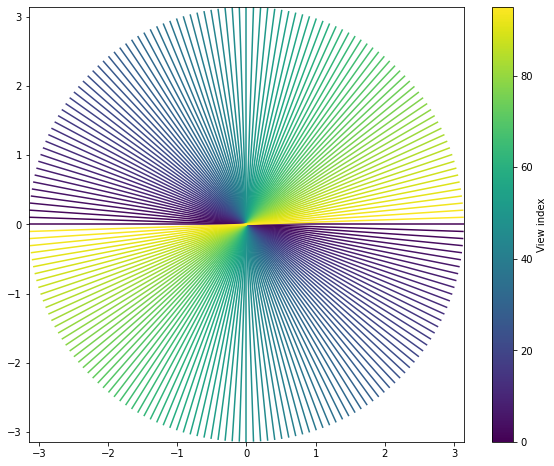

In [9]:
def plot_trajectory_2d(trajectory):
  """Plots a 2D trajectory.

  Args:
    trajectory: An array of shape `[views, samples, 2]` containing the
      trajectory.

  Returns:
    A `matplotlib.collections.LineCollection` object.
  """
  fig, ax = plt.subplots(figsize=(10, 8))
  ax.set_xlim(-np.pi, np.pi)
  ax.set_ylim(-np.pi, np.pi)
  ax.set_aspect('equal')

  # Create a line collection and add it to axis.
  lines = mcol.LineCollection(trajectory)
  lines.set_array(range(trajectory.shape[0]))
  ax.add_collection(lines)

  # Add colorbar.
  cb_ax = fig.colorbar(lines)
  cb_ax.set_label('View index')

  return lines

_ = plot_trajectory_2d(tf.reshape(trajectory, [96, -1, 2]))

As you can see, it consists of a series of 96 uniformly spaced, sequentially
acquired radial spokes extending to the edges of *k*-space ($\pi$).

## Compute density compensation weights

Non-Cartesian trajectories do not usually sample *k*-space uniformly. It's
obvious from the figure above that the center of *k*-space is much more densely
sampled than its edges.

It can be useful to explicitly account for this during image reconstruction. In
order to do that, we need to estimate the sampling density of the trajectory.
TFMRI provides several ways to obtain this estimate. The most flexible is
[tfmri.sampling.estimate_density](https://mrphys.github.io/tensorflow-mri/api_docs/tfmri/sampling/estimate_density),
which works for arbitrary trajectories.

The [tfmri.sampling](https://mrphys.github.io/tensorflow-mri/api_docs/tfmri/sampling)
module also contains other operators to compute trajectories and densities.

In [10]:
density = tfmri.sampling.estimate_density(trajectory, image_shape)

print("density shape:", density.shape)

density shape: (49152,)


## Perform zero-filled reconstruction

We are now ready to perform a basic zero-filled reconstruction. The easiest
way to do this with TensorFlow MRI is using the function
[tfmri.recon.adjoint](https://mrphys.github.io/tensorflow-mri/api_docs/tfmri/recon/adjoint).

The [tfmri.recon](https://mrphys.github.io/tensorflow-mri/api_docs/tfmri/recon)
module has several high-level interfaces for image reconstruction. The `adjoint`
interface performs reconstruction via application of the adjoint MRI linear
operator, which is constructed internally. See
[tfmri.linalg.LinearOperatorMRI](https://mrphys.github.io/tensorflow-mri/api_docs/tfmri/linalg/LinearOperatorMRI)
for more details on this operator. 

In [11]:
# Perform image reconstruction. For non-Cartesian reconstruction, we need to
# provide the k-space data, the shape of the output image, the trajectory and,
# optionally, the sampling density.
zf_images = tfmri.recon.adjoint(kspace, image_shape,
                                trajectory=trajectory,
                                density=density)

print("zf_images shape:", zf_images.shape)

zf_images shape: (12, 300, 300)


`tfmri.recon.adjoint` supports batches of inputs. In addition, the batch shapes of
all inputs are broadcasted to obtain the output batch shape. In this case, the
coil dimension of `kspace` was interpreted as a batch dimension (multicoil
reconstruction is only triggered when `sensitivities` are specified).
`trajectory` and `density`, which have scalar batch shapes, were broadcasted to
the same shape and all coils were reconstructed in parallel. The sample
principles would apply if reconstructing multiple images with different
trajectories.

:::{note}
Many TFMRI operators support batches of inputs. Batch dimensions are always
leading.
:::

:::{note}
TensorFlow broadcasting semantics are similar to those of NumPy. Learn more
about broadcasting [here](https://numpy.org/doc/stable/user/basics.broadcasting.html). 
:::

Let's have a look at the reconstructed images:

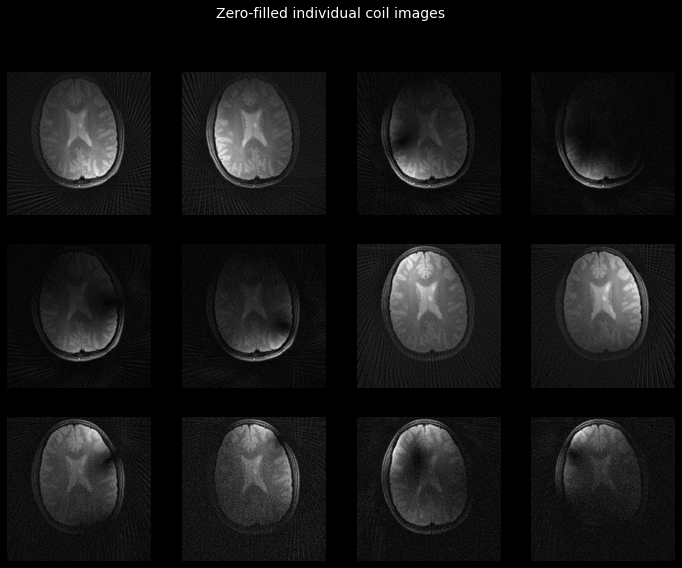

In [12]:
def plot_tiled_images(image):
  _, axs = plt.subplots(3, 4, facecolor='k', figsize=(12, 9))

  artists = []
  for index in range(12):
    col, row = index // 4, index % 4
    artists.append(
        axs[col, row].imshow(image[index, ...], cmap='gray')
    )
    axs[col, row].axis('off')
  return artists

_ = plot_tiled_images(tf.math.abs(zf_images))
_ = plt.gcf().suptitle('Zero-filled individual coil images',
                       color='w', fontsize=14)

Finally, let's combine the individual coil images into our final reconstruction.
TFMRI provides a very simple function [tfmri.coils.combine_coils](https://mrphys.github.io/tensorflow-mri/api_docs/tfmri/coils/combine_coils)
to perform coil combination via the sum-of-squares method. If coil sensitivity
estimates are available, it can also be used to perform adaptive combination.

The [tfmri.coils](https://mrphys.github.io/tensorflow-mri/api_docs/tfmri/coils)
module contains several utilities to operate with coil arrays. 

In [13]:
# Combine all coils to create the final zero-filled reconstruction.
zf_image = tfmri.coils.combine_coils(zf_images, coil_axis=0)

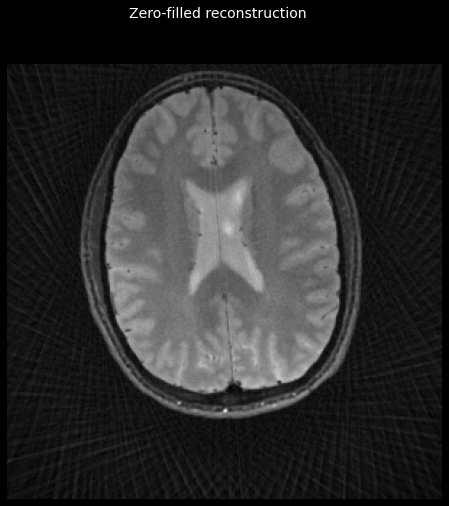

In [14]:
def plot_image(image):
  _, ax = plt.subplots(figsize=(8, 8), facecolor='k')
  artist = ax.imshow(image, cmap='gray')
  ax.set_facecolor('k')
  ax.axis('off')
  return artist

_ = plot_image(tf.math.abs(zf_image))
_ = plt.gcf().suptitle('Zero-filled reconstruction', color='w', fontsize=14)

## Compute coil sensitivity maps

The zero-filled image has visible artefact because the *k*-space sampling rate
is below the Nyquist rate. Information from multiple coils can be used more
effectively to address this problem, by performing a SENSE reconstruction.

First we need to obtain the coil sensitivity maps. These can be estimated from
the individual coil images. A low-resolution estimate of the images is suitable
for this purpose and is easy to obtain, assuming the central part of
*k*-space is sufficiently sampled.

To obtain the low resolution image estimates, we will first apply a low-pass
filter to the *k*-space data. We will be using
[tfmri.signal.hann](https://mrphys.github.io/tensorflow-mri/api_docs/tfmri/signal/hann) and
[tfmri.signal.filter_kspace](https://mrphys.github.io/tensorflow-mri/api_docs/tfmri/signal/filter_kspace).

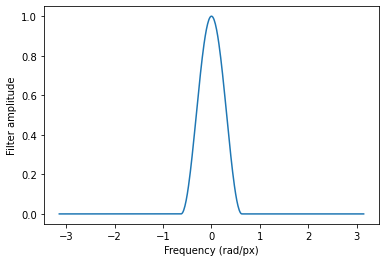

In [15]:
# First let's filter the *k*-space data with a Hann window. We will apply the
# window to the central 20% of k-space (determined by the factor 5 below), the
# remaining 80% is filtered out completely.
filter_fn = lambda x: tfmri.signal.hann(5 * x)

# Let's plot the effect of our filter.
x = tf.linspace(-np.pi, np.pi, 512)
plt.plot(x, filter_fn(x))
plt.xlabel('Frequency (rad/px)')
plt.ylabel('Filter amplitude')

# Finally, apply the filter to the k-space data.
filtered_kspace = tfmri.signal.filter_kspace(kspace,
                                             trajectory=trajectory,
                                             filter_fn=filter_fn)

We can now reconstruct the images from the filtered *k*-space data as
described in [Perform zero-filled reconstruction](#perform-zero-filled-reconstruction).

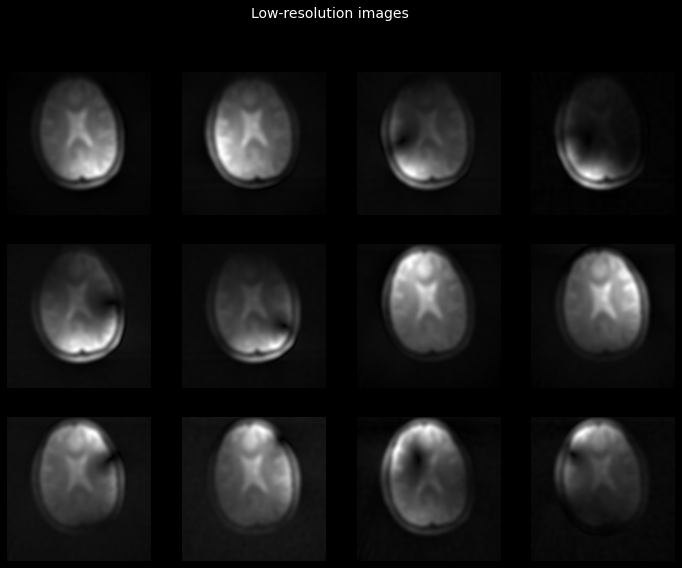

In [16]:
low_res_images = tfmri.recon.adjoint(filtered_kspace,
                                     image_shape,
                                     trajectory=trajectory,
                                     density=density)

_ = plot_tiled_images(tf.math.abs(low_res_images))
_ = plt.gcf().suptitle('Low-resolution images', color='w', fontsize=14)

Let's now use these images to obtain the coil sensitivity maps. We will use
Walsh's method, one of the methods implemented in
[tfmri.coils.estimate_sensitivities](https://mrphys.github.io/tensorflow-mri/api_docs/tfmri/coils/estimate_sensitivities).

2022-06-16 20:56:07.292315: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


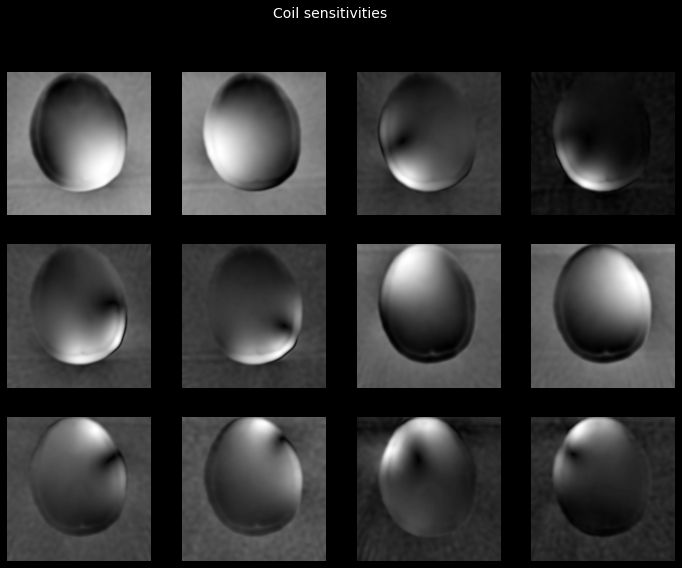

In [17]:
sensitivities = tfmri.coils.estimate_sensitivities(
    low_res_images, coil_axis=0, method='walsh')

_ = plot_tiled_images(tf.math.abs(sensitivities))
_ = plt.gcf().suptitle('Coil sensitivities', color='w', fontsize=14)

## Perform CG-SENSE reconstruction

We are finally ready to perform the SENSE reconstruction! We will be using
another of the high-level interfaces in `tfmri.recon`. In this case, we will use
[tfmri.recon.least_squares](https://mrphys.github.io/tensorflow-mri/api_docs/tfmri/recon/least_squares).
This interface can be used for image reconstruction methods that arise from
a least-squares formulation, like CG-SENSE. Internally, this function will
create a [tfmri.linalg.LinearOperatorMRI](https://mrphys.github.io/tensorflow-mri/api_docs/tfmri/linalg/LinearOperatorMRI)
and solve the linear system using [tfmri.linalg.conjugate_gradient](https://mrphys.github.io/tensorflow-mri/api_docs/tfmri/linalg/conjugate_gradient).

Usage is similar to `tfmri.recon.adjoint`, so let's have a look:

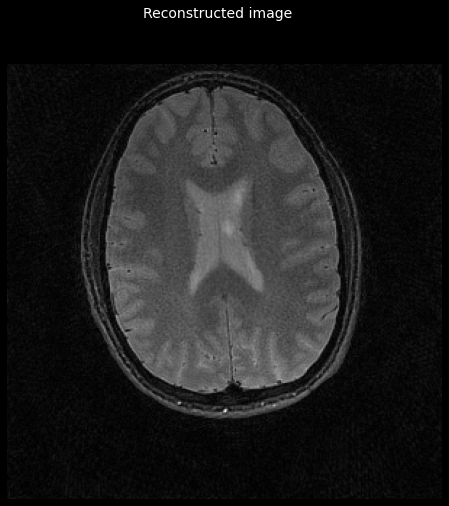

In [18]:
image = tfmri.recon.least_squares(kspace, image_shape,
                                  # Provide trajectory.
                                  trajectory=trajectory,
                                  # Density is optional! But it might speed up
                                  # convergence.
                                  density=density,
                                  # Provide the coil sensitivities. Otherwise
                                  # this is just an iterative inverse NUFFT.
                                  sensitivities=sensitivities,
                                  # Use conjugate gradient.
                                  optimizer='cg',
                                  # Pass any additional arguments to the
                                  # optimizer.
                                  optimizer_kwargs={
                                      'max_iterations': 10
                                  },
                                  # Filter out the areas of *k*-space outside
                                  # the support of the trajectory.
                                  filter_corners=True)

_ = plot_image(tf.math.abs(image))
_ = plt.gcf().suptitle('Reconstructed image', color='w', fontsize=14)

### Add Tikhonov regularization

`tfmri.recon.least_squares` supports regularization. Tikhonov regularization can help
improve the conditioning of a linear system. In its simplest form, it simply
favors solutions with a low L2 norm, which can help to reduce the amount of
noise.

A regularizer can be specified using the `regularizer` argument of `least_squares`.
This object depends on the type of problem but in most circumstances it should
be a [tfmri.convex.ConvexFunction](https://mrphys.github.io/tensorflow-mri/api_docs/tfmri/convex/ConvexFunction).
For Tikhonov regularization, we can use
[tfmri.convex.ConvexFunctionTikhonov](https://mrphys.github.io/tensorflow-mri/api_docs/tfmri/convex/ConvexFunctionTikhonov).

:::{note}
The [tfmri.convex](https://mrphys.github.io/tensorflow-mri/api_docs/tfmri/convex)
module contains many more operators for convex optimization.
:::

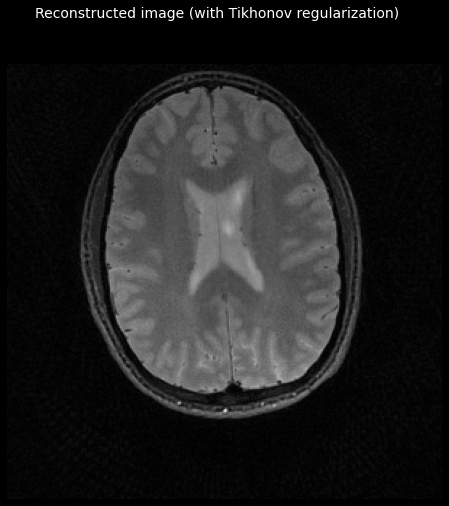

In [19]:
# Create the regularizer. We specify the `scale` argument (the regularization
# factor) and the input dtype.
regularizer = tfmri.convex.ConvexFunctionTikhonov(scale=0.2, dtype=tf.complex64)

reg_image = tfmri.recon.least_squares(kspace, image_shape,
                                      trajectory=trajectory,
                                      density=density,
                                      sensitivities=sensitivities,
                                      regularizer=regularizer,
                                      optimizer='cg',
                                      optimizer_kwargs={
                                          'max_iterations': 10
                                      },
                                      filter_corners=True)

_ = plot_image(tf.math.abs(reg_image))
_ = plt.gcf().suptitle('Reconstructed image (with Tikhonov regularization)',
                       color='w', fontsize=14)

## Consolidate previous steps

Let's put together our entire reconstruction pipeline in a single
function:

In [20]:
def reconstruct_cgsense(kspace, image_shape, trajectory,
                        tikhonov_parameter=None):
  """Reconstructs an MR image using CG-SENSE.

  Sampling density and coil sensitivities are estimated automatically.

  Args:
    kspace: A `tf.Tensor` of shape `[coils, views * samples]` containing the
      measured k-space data.
    image_shape: A `list` or `tf.TensorShape` specifying the shape of the image
      to reconstruct.
    trajectory: A `tf.Tensor` of shape `[views * samples, rank]` containing the
      sampling locations.
    tikhonov_parameter: A `float` specifying the Tikhonov regularization
      parameter. If `None`, no regularization is applied.

  Returns:
    A `tf.Tensor` of shape `image_shape` containing the reconstructed image.
  """
  # Estimate the sampling density.
  density = tfmri.sampling.estimate_density(trajectory, image_shape)

  # Low-pass filtering of the k-space data.
  filtered_kspace = tfmri.signal.filter_kspace(kspace,
                                               trajectory=trajectory,
                                               filter_fn=filter_fn)

  # Reconstruct low resolution estimates.
  low_res_images = tfmri.recon.adjoint(filtered_kspace,
                                       image_shape,
                                       trajectory=trajectory,
                                       density=density)

  # Estimate the coil sensitivities.
  sensitivities = tfmri.coils.estimate_sensitivities(
      low_res_images, coil_axis=0, method='walsh')

  # Create regularizer.
  if tikhonov_parameter is not None:
    regularizer = tfmri.convex.ConvexFunctionTikhonov(
        scale=tikhonov_parameter, dtype=tf.complex64)
  else:
    regularizer = None

  # Perform the reconstruction.
  return tfmri.recon.least_squares(kspace, image_shape,
                                   trajectory=trajectory,
                                   density=density,
                                   sensitivities=sensitivities,
                                   regularizer=regularizer,
                                   optimizer='cg',
                                   optimizer_kwargs={
                                       'max_iterations': 10
                                   },
                                   filter_corners=True)

To make things more interesting, let's test it with some new data! We'll use
a cardiac dataset which was also provided by the ISMRM Reproducibility
Challenge 1. 

In [21]:
heart_data_filename = 'rawdata_heart_radial_55proj_34ch.h5'
heart_data_url = "https://github.com/ISMRM/rrsg/raw/master/challenges/challenge_01/rawdata_heart_radial_55proj_34ch.h5"
!wget --quiet -O {heart_data_filename} {heart_data_url}

--2022-06-16 20:56:15--  https://github.com/ISMRM/rrsg/raw/master/challenges/challenge_01/rawdata_heart_radial_55proj_34ch.h5
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ISMRM/rrsg/master/challenges/challenge_01/rawdata_heart_radial_55proj_34ch.h5 [following]
--2022-06-16 20:56:16--  https://raw.githubusercontent.com/ISMRM/rrsg/master/challenges/challenge_01/rawdata_heart_radial_55proj_34ch.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5000544 (4.8M) [application/octet-stream]
Saving to: ‘rawdata_heart_radial_55proj_34ch.h5’

rawdata_heart_radia 100%[===================>]   4.77M  12.3M

Let's read the data and process it in the same way as before:

In [22]:
with h5py.File('rawdata_heart_radial_55proj_34ch.h5', 'r') as f:
  kspace = f['rawdata'][()]
  trajectory = f['trajectory'][()]

image_shape = [240, 240]

# Convert k-space to TFMRI format.
kspace = tf.squeeze(kspace, axis=0)
kspace = tf.transpose(kspace)
kspace = tf.reshape(kspace, [34, -1])

# Convert trajectory to TFMRI format.
trajectory = tf.transpose(trajectory)
trajectory = tf.reshape(trajectory, [-1, 3])
trajectory = trajectory[..., :2]
trajectory *= 2.0 * np.pi / tf.constant(image_shape, dtype=tf.float32)
trajectory *= tf.constant([-1., 1.])

Now perform the reconstruction:

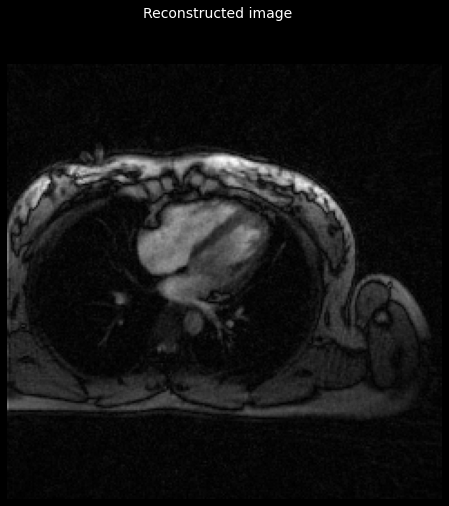

In [23]:
image = reconstruct_cgsense(kspace, image_shape, trajectory,
                            tikhonov_parameter=0.2)

_ = plot_image(tf.math.abs(image))
_ = plt.gcf().suptitle('Reconstructed image', color='w', fontsize=14)

## Conclusion
Congratulations! You performed a non-Cartesian CG-SENSE reconstruction using
TensorFlow MRI. The code used in this notebook works for any dataset and
trajectory. It also works for 3D imaging. Feel free to try with your own data!

For more information about the functions used in this tutorial, check out the
[API documentation](https://mrphys.github.io/tensorflow-mri/api_docs/). For
more examples of using TensorFlow MRI, check out the
[tutorials](https://mrphys.github.io/tensorflow-mri/tutorials/).

### Let us know!
Please tell us what you think about this tutorial and about TensorFlow MRI.
We would like to hear what you liked and how we can improve. You will find us
on [GitHub](https://github.com/mrphys/tensorflow-mri/issues/new).

In [24]:
# Copyright 2022 University College London. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.